In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Note: this was a notebook made to make RK4 work with adaptive time step. Then, the working parts were transferred to three_body_animation.py for the animation to work

# Euler method first

$\mathbf{r}(t+h) = \mathbf{r}(t) + h \mathbf{f}(\mathbf{r},t)$,

$\mathbf{f}(\mathbf{r},t) = (f_x (\mathbf{r},t), f_y (\mathbf{r},t), ...)$

In [2]:

def f(u0, v0, w0, m1, m2, m3, G, eps=1e-12):

    r_uv = v0 - u0
    r_uw = w0 - u0
    r_wv = w0 - v0
    r_vu = u0 - v0
    r_wu = u0 - w0
    r_vw = v0 - w0

    def inv_r3(r):
        rnorm = np.linalg.norm(r)
        return 1.0 / ((rnorm + eps)**3)

    a_u = G * ( m2 * r_uv * inv_r3(r_uv) + m3 * r_uw * inv_r3(r_uw) )
    a_v = G * ( m3 * r_wv * inv_r3(r_wv) + m1 * r_vu * inv_r3(r_vu) )
    a_w = G * ( m1 * r_wu * inv_r3(r_wu) + m2 * r_vw * inv_r3(r_vw) )

    return a_u, a_v, a_w

def euler_threebody(u0_0, u0_1, v0_0, v0_1, w0_0, w0_1,
                    m1, m2, m3, G,
                    dt, n_steps):
    # u0_0 = initial u0 position (vector), u0_1 = initial u1 (velocity) etc.
    dim = u0_0.shape[0]
    traj = {
        'u_pos': np.zeros((n_steps+1, dim)),
        'u_vel': np.zeros((n_steps+1, dim)),
        'v_pos': np.zeros((n_steps+1, dim)),
        'v_vel': np.zeros((n_steps+1, dim)),
        'w_pos': np.zeros((n_steps+1, dim)),
        'w_vel': np.zeros((n_steps+1, dim)),
        't': np.zeros(n_steps+1)
    }

    # initialize
    u_pos = u0_0.copy()
    u_vel = u0_1.copy()
    v_pos = v0_0.copy()
    v_vel = v0_1.copy()
    w_pos = w0_0.copy()
    w_vel = w0_1.copy()

    traj['u_pos'][0] = u_pos
    traj['u_vel'][0] = u_vel
    traj['v_pos'][0] = v_pos
    traj['v_vel'][0] = v_vel
    traj['w_pos'][0] = w_pos
    traj['w_vel'][0] = w_vel

    for n in range(n_steps):
        # compute accelerations from current positions
        a_u, a_v, a_w = f(u_pos, v_pos, w_pos, m1, m2, m3, G)

        # Euler update (forward)
        u_pos = u_pos + dt * u_vel
        v_pos = v_pos + dt * v_vel
        w_pos = w_pos + dt * w_vel

        u_vel = u_vel + dt * a_u
        v_vel = v_vel + dt * a_v
        w_vel = w_vel + dt * a_w

        traj['u_pos'][n+1] = u_pos
        traj['u_vel'][n+1] = u_vel
        traj['v_pos'][n+1] = v_pos
        traj['v_vel'][n+1] = v_vel
        traj['w_pos'][n+1] = w_pos
        traj['w_vel'][n+1] = w_vel
        traj['t'][n+1] = traj['t'][n] + dt

    return traj

In [11]:
# constants
G = 1.0
m1, m2, m3 = 150.0, 200.0, 250.0
dt = 1e-4
n_steps = 100000

# initial positions and velocities (2D)
u0_pos = np.array([ 3.0, 1.0 ])
u0_vel = np.array([  0.0, 0.0 ])
v0_pos = np.array([  -1.0, -2.0 ])
v0_vel = np.array([  0.0, 0.0 ])
w0_pos = np.array([  -1.0, 1.0 ])
w0_vel = np.array([  0.0, 0.0 ])

traj = euler_threebody(u0_pos, u0_vel, v0_pos, v0_vel, w0_pos, w0_vel,
                       m1, m2, m3, G, dt, n_steps)
# traj['u_pos'] is an (n_steps+1,3) array, etc.

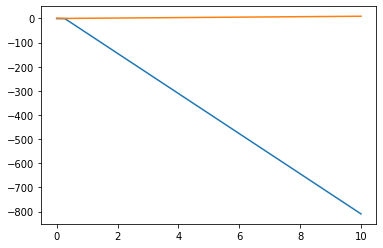

In [19]:
plt.plot(traj['t'], traj['w_pos'][:,0], label='mass 1')
plt.plot(traj['t'], traj['w_pos'][:,1], label='mass 2')
# plt.plot(traj['v_pos'][:,0], traj['v_pos'][:,1], label='mass 2')
# plt.plot(traj['w_pos'][:,0], traj['w_pos'][:,1], label='mass 3')


In [20]:
def euler_adaptive(u0, u1, v0, v1, w0, w1,
                   m1, m2, m3, G,
                   h_init=1e-3, tol=1e-6, t_end=10.0,
                   safety=0.9, max_factor=2.0, min_factor=0.5):

    t, h = 0.0, h_init
    traj = {'t': [t],
            'u_pos': [u0.copy()], 'u_vel': [u1.copy()],
            'v_pos': [v0.copy()], 'v_vel': [v1.copy()],
            'w_pos': [w0.copy()], 'w_vel': [w1.copy()]}

    while t < t_end:
        if t + h > t_end:
            h = t_end - t

        # --- Single Euler step (size h)
        a_u, a_v, a_w = f(u0, v0, w0, m1, m2, m3, G)
        u0_e = u0 + h*u1
        v0_e = v0 + h*v1
        w0_e = w0 + h*w1
        u1_e = u1 + h*a_u
        v1_e = v1 + h*a_v
        w1_e = w1 + h*a_w

        # --- Two half-Euler steps (size h/2)
        h2 = h/2
        # First half-step
        a_u1, a_v1, a_w1 = a_u, a_v, a_w
        u0_half = u0 + h2*u1
        v0_half = v0 + h2*v1
        w0_half = w0 + h2*w1
        u1_half = u1 + h2*a_u1
        v1_half = v1 + h2*a_v1
        w1_half = w1 + h2*a_w1
        # Second half-step
        a_u2, a_v2, a_w2 = f(u0_half, v0_half, w0_half, m1, m2, m3, G)
        u0_2h = u0_half + h2*u1_half
        v0_2h = v0_half + h2*v1_half
        w0_2h = w0_half + h2*w1_half
        u1_2h = u1_half + h2*a_u2
        v1_2h = v1_half + h2*a_v2
        w1_2h = w1_half + h2*a_w2

        # --- Error estimate (positions + velocities)
        err = max(np.linalg.norm(u0_2h - u0_e),
                  np.linalg.norm(v0_2h - v0_e),
                  np.linalg.norm(w0_2h - w0_e),
                  np.linalg.norm(u1_2h - u1_e),
                  np.linalg.norm(v1_2h - v1_e),
                  np.linalg.norm(w1_2h - w1_e))

        # --- Accept/reject and adjust step
        if err < tol:
            # Accept
            t += h
            u0, u1 = u0_2h, u1_2h
            v0, v1 = v0_2h, v1_2h
            w0, w1 = w0_2h, w1_2h
            traj['t'].append(t)
            traj['u_pos'].append(u0.copy()); traj['u_vel'].append(u1.copy())
            traj['v_pos'].append(v0.copy()); traj['v_vel'].append(v1.copy())
            traj['w_pos'].append(w0.copy()); traj['w_vel'].append(w1.copy())
            # Update step size (proportional control)
            h = min(max_factor*h, h * safety * (tol/err)**0.5)
        else:
            # Reject and shrink step
            h = max(min_factor*h, h * safety * (tol/err)**0.5)

    for key in traj:
        traj[key] = np.array(traj[key])
    return traj


In [23]:
# constants
G = 1.0
m1, m2, m3 = 150.0, 200.0, 250.0

# initial positions and velocities (2D)
u0_pos = np.array([ 3.0, 1.0 ])
u0_vel = np.array([  0.0, 0.0 ])
v0_pos = np.array([  -1.0, -2.0 ])
v0_vel = np.array([  0.0, 0.0 ])
w0_pos = np.array([  -1.0, 1.0 ])
w0_vel = np.array([  0.0, 0.0 ])

traj = euler_adaptive(u0_pos, u0_vel, v0_pos, v0_vel, w0_pos, w0_vel,
                      m1, m2, m3, G,
                      h_init=1e-3, tol=1e-3, t_end=10.0)
print("Final time:", traj['t'][-1], "steps:", len(traj['t']))

Final time: 10.0 steps: 6507


In [43]:
# constants
G = 1.0
m1, m2, m3 = 150.0, 200.0, 250.0

# initial positions and velocities (2D)
u0_pos = np.array([ 0.0, 0.0 ])
u0_vel = np.array([ 0.93240737, 0.86473146 ])
v0_pos = np.array([ 0.97000436, -0.24308753 ])
v0_vel = np.array([ -0.46620369, -0.43236573 ])
w0_pos = np.array([ -0.97000436, 0.24308753 ])
w0_vel = np.array([ -0.46620369, -0.43236573 ])

traj = euler_adaptive(u0_pos, u0_vel, v0_pos, v0_vel, w0_pos, w0_vel,
                      m1, m2, m3, G,
                      h_init=1e-3, tol=1e-3, t_end=10.0)
print("Final time:", traj['t'][-1], "steps:", len(traj['t']))

Final time: 10.0 steps: 7815


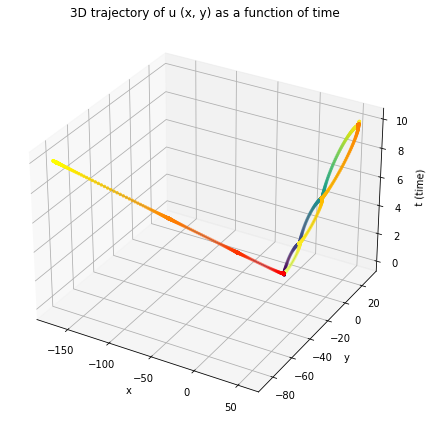

In [44]:
# extract data
x1 = traj['u_pos'][:, 0]
y1 = traj['u_pos'][:, 1]
x2 = traj['v_pos'][:, 0]
y2 = traj['v_pos'][:, 1]
x3 = traj['w_pos'][:, 0]
y3 = traj['w_pos'][:, 1]

z = traj['t']

# downsample for scatter overlay if very long
stride = max(1, len(z) // 2000)
sc_ix = np.arange(0, len(z), stride)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# 3D line of (x, y, t)
ax.plot(x1, y1, z, lw=1.0, color='C0', label='trajectory')
ax.plot(x2, y2, z, lw=1.0, color='C1', label='trajectory')
ax.plot(x3, y3, z, lw=1.0, color='C2', label='trajectory')

# colored scatter to show progression in time
sc1 = ax.scatter(x1[sc_ix], y1[sc_ix], z[sc_ix],
                c=z[sc_ix], cmap='autumn', s=6, marker='o')
sc2 = ax.scatter(x2[sc_ix], y2[sc_ix], z[sc_ix],
                c=z[sc_ix], cmap='viridis', s=6, marker='o')
sc3 = ax.scatter(x3[sc_ix], y3[sc_ix], z[sc_ix],
                c=z[sc_ix], cmap='Wistia', s=6, marker='o')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('t (time)')
ax.set_title("3D trajectory of u (x, y) as a function of time")
ax.view_init(elev=30, azim=-60)
# fig.colorbar(sc, ax=ax, label='time (t)')

plt.tight_layout()
plt.show()

In [47]:
import numpy as np

def accel(u0, v0, w0, m1, m2, m3, G, eps=1e-9):
    """Compute accelerations on each body due to the others."""
    def f(r1, r2):
        r = r2 - r1
        r2norm = np.dot(r, r) + eps*eps
        return r / (r2norm * np.sqrt(r2norm))
    
    a_u = G * (m2 * f(u0, v0) + m3 * f(u0, w0))
    a_v = G * (m3 * f(v0, w0) + m1 * f(v0, u0))
    a_w = G * (m1 * f(w0, u0) + m2 * f(w0, v0))
    return a_u, a_v, a_w


def rk4_step(u0, u1, v0, v1, w0, w1, m1, m2, m3, G, dt):
    """Perform a single fixed RK4 step."""
    a1u, a1v, a1w = accel(u0, v0, w0, m1, m2, m3, G)
    k1_ru, k1_rv, k1_rw = u1, v1, w1
    k1_vu, k1_vv, k1_vw = a1u, a1v, a1w

    ru2 = u0 + 0.5*dt*k1_ru
    rv2 = v0 + 0.5*dt*k1_rv
    rw2 = w0 + 0.5*dt*k1_rw
    vu2 = u1 + 0.5*dt*k1_vu
    vv2 = v1 + 0.5*dt*k1_vv
    vw2 = w1 + 0.5*dt*k1_vw
    a2u, a2v, a2w = accel(ru2, rv2, rw2, m1, m2, m3, G)
    k2_ru, k2_rv, k2_rw = vu2, vv2, vw2
    k2_vu, k2_vv, k2_vw = a2u, a2v, a2w

    ru3 = u0 + 0.5*dt*k2_ru
    rv3 = v0 + 0.5*dt*k2_rv
    rw3 = w0 + 0.5*dt*k2_rw
    vu3 = u1 + 0.5*dt*k2_vu
    vv3 = v1 + 0.5*dt*k2_vv
    vw3 = w1 + 0.5*dt*k2_vw
    a3u, a3v, a3w = accel(ru3, rv3, rw3, m1, m2, m3, G)
    k3_ru, k3_rv, k3_rw = vu3, vv3, vw3
    k3_vu, k3_vv, k3_vw = a3u, a3v, a3w

    ru4 = u0 + dt*k3_ru
    rv4 = v0 + dt*k3_rv
    rw4 = w0 + dt*k3_rw
    vu4 = u1 + dt*k3_vu
    vv4 = v1 + dt*k3_vv
    vw4 = w1 + dt*k3_vw
    a4u, a4v, a4w = accel(ru4, rv4, rw4, m1, m2, m3, G)
    k4_ru, k4_rv, k4_rw = vu4, vv4, vw4
    k4_vu, k4_vv, k4_vw = a4u, a4v, a4w

    u0_new = u0 + (dt/6.0)*(k1_ru + 2*k2_ru + 2*k3_ru + k4_ru)
    v0_new = v0 + (dt/6.0)*(k1_rv + 2*k2_rv + 2*k3_rv + k4_rv)
    w0_new = w0 + (dt/6.0)*(k1_rw + 2*k2_rw + 2*k3_rw + k4_rw)
    u1_new = u1 + (dt/6.0)*(k1_vu + 2*k2_vu + 2*k3_vu + k4_vu)
    v1_new = v1 + (dt/6.0)*(k1_vv + 2*k2_vv + 2*k3_vv + k4_vv)
    w1_new = w1 + (dt/6.0)*(k1_vw + 2*k2_vw + 2*k3_vw + k4_vw)
    return u0_new, u1_new, v0_new, v1_new, w0_new, w1_new


def rk4_adaptive_threebody(u0, u1, v0, v1, w0, w1, m1, m2, m3, G, 
                           t_end, dt_init=1e-3, tol=1e-6, dt_min=1e-6, dt_max=0.05):
    """Adaptive RK4 integration with step doubling."""
    t = 0.0
    dt = dt_init

    traj = {
        't': [t],
        'u_pos': [u0.copy()],
        'v_pos': [v0.copy()],
        'w_pos': [w0.copy()],
        'u_vel': [u1.copy()],
        'v_vel': [v1.copy()],
        'w_vel': [w1.copy()],
        'dt': [dt],
    }

    while t < t_end:
        # single step (dt)
        u_a, u1_a, v_a, v1_a, w_a, w1_a = rk4_step(u0, u1, v0, v1, w0, w1, m1, m2, m3, G, dt)
        # two half steps (dt/2 twice)
        u_half, u1_half, v_half, v1_half, w_half, w1_half = rk4_step(u0, u1, v0, v1, w0, w1, m1, m2, m3, G, dt/2)
        u_b, u1_b, v_b, v1_b, w_b, w1_b = rk4_step(u_half, u1_half, v_half, v1_half, w_half, w1_half, m1, m2, m3, G, dt/2)

        # estimate local truncation error
        err_u = np.linalg.norm(u_a - u_b)
        err_v = np.linalg.norm(v_a - v_b)
        err_w = np.linalg.norm(w_a - w_b)
        err = max(err_u, err_v, err_w)

        # accept or reject
        if err < tol or dt <= dt_min:
            # accept step
            t += dt
            u0, u1, v0, v1, w0, w1 = u_b, u1_b, v_b, v1_b, w_b, w1_b
            traj['t'].append(t)
            traj['u_pos'].append(u0.copy())
            traj['v_pos'].append(v0.copy())
            traj['w_pos'].append(w0.copy())
            traj['u_vel'].append(u1.copy())
            traj['v_vel'].append(v1.copy())
            traj['w_vel'].append(w1.copy())
            traj['dt'].append(dt)
        
        # update step size
        if err == 0:
            s = 2.0
        else:
            s = 0.84 * (tol / err)**0.25
        dt = np.clip(s * dt, dt_min, dt_max)

    for key in traj:
        traj[key] = np.array(traj[key])
    return traj


In [50]:
# constants
G = 1.0
m1, m2, m3 = 150.0, 200.0, 250.0

# initial positions and velocities (2D)
u0 = np.array([ 0.0, 0.0 ])
u1 = np.array([ 0.93240737, 0.86473146 ])
v0 = np.array([ 0.97000436, -0.24308753 ])
v1 = np.array([ -0.46620369, -0.43236573 ])
w0 = np.array([ -0.97000436, 0.24308753 ])
w1 = np.array([ -0.46620369, -0.43236573 ])

u0 = np.array([ 3.0, 1.0 ])
u1 = np.array([  0.0, 0.0 ])
v0 = np.array([  -1.0, -2.0 ])
v1 = np.array([  0.0, 0.0 ])
w0 = np.array([  -1.0, 1.0 ])
w1 = np.array([  0.0, 0.0 ])

traj = rk4_adaptive_threebody(u0, u1, v0, v1, w0, w1, m1, m2, m3, G, t_end=10.0, tol=1e-6)
print("Steps taken:", len(traj['t']))


Steps taken: 749


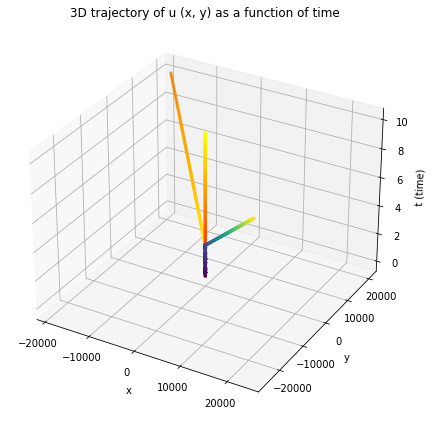

In [51]:
# extract data
x1 = traj['u_pos'][:, 0]
y1 = traj['u_pos'][:, 1]
x2 = traj['v_pos'][:, 0]
y2 = traj['v_pos'][:, 1]
x3 = traj['w_pos'][:, 0]
y3 = traj['w_pos'][:, 1]

z = traj['t']

# downsample for scatter overlay if very long
stride = max(1, len(z) // 2000)
sc_ix = np.arange(0, len(z), stride)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# 3D line of (x, y, t)
ax.plot(x1, y1, z, lw=1.0, color='C0', label='trajectory')
ax.plot(x2, y2, z, lw=1.0, color='C1', label='trajectory')
ax.plot(x3, y3, z, lw=1.0, color='C2', label='trajectory')

# colored scatter to show progression in time
sc1 = ax.scatter(x1[sc_ix], y1[sc_ix], z[sc_ix],
                c=z[sc_ix], cmap='autumn', s=6, marker='o')
sc2 = ax.scatter(x2[sc_ix], y2[sc_ix], z[sc_ix],
                c=z[sc_ix], cmap='viridis', s=6, marker='o')
sc3 = ax.scatter(x3[sc_ix], y3[sc_ix], z[sc_ix],
                c=z[sc_ix], cmap='Wistia', s=6, marker='o')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('t (time)')
ax.set_title("3D trajectory of u (x, y) as a function of time")
ax.view_init(elev=30, azim=-60)
# fig.colorbar(sc, ax=ax, label='time (t)')

plt.tight_layout()
plt.show()